# Содержание


*   **Ход рассуждений и основная идея**
*   **Основной пайплайн**
*   **Плюсы и минусы пайплайна**
*   **Способы проверки и улучшения качества!**
*   **Альтернативный подход к детекции: c помощью SAM (segment anything model)**



# Ход рассуждений и основная идея.
В данной задаче я пробовал разные подходы.
1. Первоначально использовал различные модели YOLO, однако даже самые продвинутые из них, такие как YOLOv8, не дали результата: на большинстве изображений не детектировалось ни одного класса. При уменьшении confidence некоторые объекты детектировались, но те названия, но их классификация была неверная. Решил попробовать улучшить подход.

2. Сделал комбинированную стратегию детекции с Faster R-CNN как fallback, если YOLO не детектировала ни одного объекта. Качество детекции улучшилось, но детектировались не все объекты и снова была проблема с классификацией. Например, часто можно было увидеть bounding boxes с подписью "самолёт" или "мотоцикл", хотя таковых объектов в предоставленном наборе данных нет.
От данного подхода решил отказаться.

Проблема с неправильной классификацией связана с тем, что YOLO обучена на 80 классов. Их она и пытается найти. В связи с этим я обратился к zero-shot моделям (способны детектировать новые классы, которых не было при обучении): OWL-ViT, YOLO-World.

3. Последовательная детекция через OWL-ViT и YOLO-World с предварительным заданием большого числа возможных классов (порядка 200 штук, разные бытовые предметы). Однако, несмотря на возможность находить объекты без предварительного обучения, для OWL-ViT необходимо подробное описание объекта, чтобы детектировать объект. Например, "собака лежит на траве". Но нам заранее неизвестно, что за объект может встретиться роботу, поэтому такое описание дать мы не можем.
Применяя подход, стали детектировать больше объектов, но опять же не все. И снова осталась проблема, что модель детектирует объект, например, руку робота, а классифицирует неправильно, например, sewing machine.  От данного подхода решил отказаться.

4. Использовал модель SAM (segment-anything) для сегментации и нахождения по ней bounding boxes.  
Данная модель детектирует всё, что нужно, и даже больше, в том числе тени, некоторые произвольные участки изображения, которые похожи на объекты и некоторые части объектов. Данный подход я не использовал в качестве основного пайплайна. Однако считаю, что можно попытаться доработать его. Возможно, фильтровать полученные bounding boxes по confidence, чтобы результат не был зашумлён лишними объектами. С результатами детекции вы можете ознакомиться в разделе SAM в конце ноутбука

Помимо вышеперечисленного была идея дообучить модель YOLO на размеченном вручную датасете. Однако из-за малого количества данных я посчитал, что их будет недостаточно, чтобы качественно дообучить модель.  





# Основной пайплайн

Для каждого изображения:
- Генерируем с помощью `BLIP - 2` текстовое описание изображения.
- Извлекаем с помощью функции `extract_tangible_objects` слова -- физические объекты
- Подаём данные слова как классы в модель zero - shot детекции `yolov8s-world` -> получаем bounding boxes
- Для каждого bounding box изображения генерируем описание, находим цвет с помощью `BLIP - 2`.
- Размер объекта определяем как размер bounding box'a относительно всего изображения
Сохраняем полученные описания в JSON файл.

Также в алгоритм добавлены эвристики и улучшения. Такие как объединение нескольких сильно пересекающихся bounding boxes в один.
Или например, модель `BLIP - 2` также отвечает на вопрос: Сколько раз встретился данный объект на исходном изображении.
- Если больше 1 раза, то мы оставляем все связанные с ним bounding boxes
- Иначе оставляем bounding box с наибольшим confidence

Сделано эта эвристика по той причине, что я использую очень низкий confindence, а именно 0.001, что характерно для zero - shot модели, из-за чего модель часто ошибочно детектирует и другие объекты. А добавление эвристики позволяет в случае одиночной встречи объекта на изображении найти только один соответствующий ему bounding box и не найти ошибочно другие якобы ему соответствующие.  


P.S. Пробовал стандартные значения confindence, 0.5 или 0.3 например. Тогда мы вообще ничего не детектируем. Поэтому эмпирически остановился на 0.001.

## Загрузка набора данных в Google Colab

In [ ]:
!pip install gdown
import gdown
import zipfile

In [ ]:
url = "https://drive.google.com/uc?id=1vViIEDEci5MBofCLEjfJku7fOlU3GQQX"
output = "dataset.zip"
gdown.download(url, output, quiet=False)
!ls -lh dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1vViIEDEci5MBofCLEjfJku7fOlU3GQQX
To: /content/dataset.zip
100%|██████████| 4.65M/4.65M [00:00<00:00, 171MB/s]

-rw-r--r-- 1 root root 4.5M Apr 24 15:01 dataset.zip


In [ ]:
import os
import zipfile
import shutil

dataset_path = "/content/dataset.zip"
extract_dir = "/content/dataset"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Содержимое архива:")
print(os.listdir(extract_dir))

checkpoints_path = os.path.join(extract_dir, "2", ".ipynb_checkpoints")
if os.path.exists(checkpoints_path):
    shutil.rmtree(checkpoints_path)
    print(f"Удалена папка {checkpoints_path}")

images_dir = os.path.join(extract_dir, "2")
image_files = [f for f in os.listdir(images_dir)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"\nНайдено {len(image_files)} изображений в папке '2':")
print(image_files[:5], "...")

processed_dir = "/content/processed_data"
os.makedirs(processed_dir, exist_ok=True)

for img in image_files:
    src = os.path.join(images_dir, img)
    dst = os.path.join(processed_dir, img)
    shutil.copy(src, dst)

print(f"\nГотово! Чистые данные в: {processed_dir}")
print(f"Пример файлов: {os.listdir(processed_dir)[:3]}")

Содержимое архива:
['2']
Удалена папка /content/dataset/2/.ipynb_checkpoints

Найдено 100 изображений в папке '2':
['555_788475.jpg', '676_878691.jpg', '512_785191.jpg', '506_778896.jpg', '582_804838.jpg'] ...

Готово! Чистые данные в: /content/processed_data
Пример файлов: ['555_788475.jpg', '676_878691.jpg', '512_785191.jpg']


## Загрузка модели BLIP - 2

https://huggingface.co/models?other=blip-2

In [ ]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto", load_in_8bit=True) # load in int8

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

## Загрузка YOLO - World

In [ ]:
!pip install ultralytics
from ultralytics import YOLO
YOLO_world_model = YOLO('yolov8s-world.pt').to(device)

## Реализация основного пайплайна

In [ ]:
from collections import OrderedDict
import numpy as np
import spacy
from spacy.tokens import Token
import json
import cv2
from tqdm import tqdm
from collections import defaultdict
import math
import os
import re
from PIL import Image
nlp = spacy.load("en_core_web_sm")

In [ ]:
def extract_tangible_objects(text):
    """
    Извлекает физические объекты из текста, сохраняя их оригинальную форму (не лемматизирует).
    Возвращает список кортежей: (original_word, is_plural).
    """
    doc = nlp(text)
    tangible_objects = set()

    for token in doc:
        if token.pos_ not in ("NOUN", "PROPN"):
            continue

        abstract_terms = {"picture", 'image'}
        if token.lemma_.lower() in abstract_terms:
            continue

        is_plural = (token.tag_ == "NNS")

        tangible_objects.add(token.text.lower())

    return list(tangible_objects)

In [ ]:
def extract_color(text):
    """
    Извлекает из текста (ответа модели BLIP-2) цвет объекта
    """
    detected_colors = []
    colors = ["black", "white", "gray", "silver", "red", "dark red",
              "burgundy", "brown", "maroon", "orange", "gold", "peach",
              "salmon", "coral", "pink", "blue", "navy", "light blue",
              "sky blue", "cyan", "turquoise", "green", "dark green",
              "lime", "olive", "mint", "purple", "indigo", "violet",
              "yellow", "white", "orange", "brown", "cyan", "magenta",
              "gold", "silver", "steel"]
    for color in colors:
        if color in text:
            detected_colors.append(color)
            break
    return detected_colors

In [ ]:
def categorize_size(area, image_area):
    """Категоризирует размер относительно общего размера изображения"""
    ratio = area / image_area
    if ratio < 0.01:
        return "small"
    elif ratio < 0.1:
        return "medium"
    else:
        return "large"

In [ ]:
def generate_box_caption(crop_pil, prompt = None):
    '''
    Генерирует описание объекта, находящегося в заданном bounding box
    '''
    if prompt:
        try:
            if crop_pil.mode != 'RGB':
                crop_pil = crop_pil.convert('RGB')

            inputs = processor(images=crop_pil, text = prompt, return_tensors="pt").to(device)
            generated_ids = model.generate(**inputs, max_new_tokens=20)
            caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

            return caption

        except Exception as e:
            print(f"Error generating description for object: {e}")
            return "Unknown"
    else:
        try:
            if crop_pil.mode != 'RGB':
                crop_pil = crop_pil.convert('RGB')

            inputs = processor(images=crop_pil, return_tensors="pt").to(device)
            generated_ids = model.generate(**inputs, max_new_tokens=20)
            caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

            return caption

        except Exception as e:
            print(f"Error generating caption for box: {e}")
            return "Unknown object"

In [ ]:
def merge_boxes(box1, box2):
    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])
    x2 = max(box1[2], box2[2])
    y2 = max(box1[3], box2[3])
    return [x1, y1, x2, y2]

In [ ]:
def calculate_iou(box1, box2):
    """
    Вычисляет IoU (Intersection over Union) двух боксов
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = area1 + area2 - inter_area

    return inter_area / union_area if union_area > 0 else 0

In [ ]:
def calculate_overlaps(box1, box2):
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    x_left = max(x1_1, x1_2)
    y_top = max(y1_1, y1_2)
    x_right = min(x2_1, x2_2)
    y_bottom = min(y2_1, y2_2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0, 0.0, 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area if union_area > 0 else 0.0
    overlap_ratio1 = intersection_area / box1_area if box1_area > 0 else 0.0
    overlap_ratio2 = intersection_area / box2_area if box2_area > 0 else 0.0

    return iou, overlap_ratio1, overlap_ratio2

In [ ]:
def non_max_suppression(detections, iou_thresh=0.1):
    """
    Применяет NMS: удаляет перекрывающиеся боксы с меньшей уверенностью
    """
    detections = sorted(detections, key=lambda x: -x[1])
    result = []

    while detections:
        curr = detections.pop(0)
        result.append(curr)
        detections = [d for d in detections if calculate_iou(curr[0], d[0]) < iou_thresh]

    return result

In [ ]:
def get_spatial_relation(center1, center2):
    """
    Определяет пространственное отношение между двумя объектами.
    """
    dx = center2[0] - center1[0]
    dy = center2[1] - center1[1]

    angle = math.degrees(math.atan2(dy, dx)) % 360

    if 337.5 <= angle or angle < 22.5:
        return "left of"
    elif 22.5 <= angle < 67.5:
        return "above-left of"
    elif 67.5 <= angle < 112.5:
        return "above"
    elif 112.5 <= angle < 157.5:
        return "above-right of"
    elif 157.5 <= angle < 202.5:
        return "right of"
    elif 202.5 <= angle < 247.5:
        return "below-right of"
    elif 247.5 <= angle < 292.5:
        return "below"
    elif 292.5 <= angle < 337.5:
        return "below-left of"

In [ ]:
def format_annotation(image_name, description, image_np, objects, detections):
    """
    Формирует аннотацию к изображению: описание изображения, пространственные отношения между объектами; название, цвет, описание, bounding boxes объектов
    """
    result = {
        "image_name": image_name,
        "description": description,
        "objects": [],
        "2d_bbox": []
    }

    image_area = image_np.shape[0] * image_np.shape[1]
    name_counters = defaultdict(int)
    bbox_objects = []

    for bbox, score, cls_id in detections:
        raw_name = objects[cls_id] if cls_id < len(objects) else f"class_{cls_id}"
        name_counters[raw_name] += 1
        obj_name = f"{raw_name}_{name_counters[raw_name]}"

        x1, y1, x2, y2 = map(int, bbox)
        crop_np = image_np[y1:y2, x1:x2]
        crop_pil = Image.fromarray(crop_np)

        s = generate_box_caption(crop_pil, "Question: What color has this object? Answer:")
        colors = extract_color(s.lower())
        color_name = " ".join(colors)

        area = (x2 - x1) * (y2 - y1)
        size_str = f"{x2 - x1}x{y2 - y1} (area={area})"
        size_category = categorize_size(area, image_area)

        try:
            if raw_name == 'robotic arms':
                obj_description = f"{color_name} {raw_name}"
            else:
                obj_description = generate_box_caption(crop_pil, f'{color_name} {raw_name}')
        except Exception as e:
            print(f"Error generating caption for box: {e}")
            obj_description = f"Detected with confidence {score:.2f}"

        result["objects"].append({
            "name": obj_name,
            "color": f"{color_name}",
            "size": f"{size_category}: {size_str}",
            "description": obj_description
        })

        result["2d_bbox"].append({
            "object": obj_name,
            "bbox": [x1, y1, x2, y2]
        })

        bbox_objects.append({
            "object": obj_name,
            "bbox": [x1, y1, x2, y2]
        })

    seen_pairs = set()
    grouped_relations = {
        "left of": [],
        "right of": [],
        "above": [],
        "below": [],
        "above-left of": [],
        "above-right of": [],
        "below-left of": [],
        "below-right of": []
    }

    for i in range(len(bbox_objects)):
        for j in range(len(bbox_objects)):
            if i == j:
                continue
            obj1 = bbox_objects[i]
            obj2 = bbox_objects[j]
            pair_key = tuple(sorted([obj1["object"], obj2["object"]]))
            if pair_key in seen_pairs:
                continue

            seen_pairs.add(pair_key)
            x1_1, y1_1, x2_1, y2_1 = obj1["bbox"]
            x1_2, y1_2, x2_2, y2_2 = obj2["bbox"]
            center1 = ((x1_1 + x2_1) // 2, (y1_1 + y2_1) // 2)
            center2 = ((x1_2 + x2_2) // 2, (y1_2 + y2_2) // 2)

            relation = get_spatial_relation(center1, center2)

            if relation in grouped_relations:
                grouped_relations[relation].append(f"{obj1['object']} is {relation} {obj2['object']}")

    relation_text = []
    for key in ["above", "below", "left of", "right of",
               "above-left of", "above-right of",
               "below-left of", "below-right of"]:
        if grouped_relations[key]:
            lines = list(set(grouped_relations[key]))
            relation_text.append(f"{key.capitalize()} relations: " + ", ".join(lines))

    if relation_text:
        result["description"] += "\nObject relations:\n" + "\n".join(relation_text)

    return result

In [ ]:
def process_image(image_path, output_vis_dir='results', output_json_dir='annotations'):
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    image_name = os.path.basename(image_path)

    try:
        inputs = processor(image, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs, max_new_tokens=200)
        description = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

        objects = extract_tangible_objects(description) + ['robot arm']
        if not objects:
            return None

        YOLO_world_model = YOLO('yolov8s-world.pt').to(device)
        YOLO_world_model.set_classes(objects)
        results = YOLO_world_model.predict(image, conf=0.001, verbose = False)

        xyxy = results[0].boxes.xyxy.cpu().numpy()
        conf = results[0].boxes.conf.cpu().numpy()
        cls = results[0].boxes.cls.cpu().numpy().astype(int)

        filtered_detections = process_detections(image, xyxy, conf, cls, objects, overlap_threshold=0.3)

        vis_image = visualize_detections(image_np, filtered_detections, objects)
        vis_image_bgr = cv2.cvtColor(vis_image, cv2.COLOR_RGB2BGR)

        os.makedirs(output_vis_dir, exist_ok=True)
        output_img_path = os.path.join(output_vis_dir, f"vis_{image_name}")
        cv2.imwrite(output_img_path, vis_image_bgr)

        annotation = format_annotation(image_name, description, image_np, objects, filtered_detections)

        os.makedirs(output_json_dir, exist_ok=True)
        json_path = os.path.join(output_json_dir, f"{os.path.splitext(image_name)[0]}.json")
        with open(json_path, 'w') as f:
            json.dump(annotation, f, indent=2)

        return annotation

    except Exception as e:
        print(f"Error processing {image_name}: {str(e)}")
        return None

In [ ]:
def process_folder(input_folder, output_json="annotations.json"):
    annotations = []
    image_files = [f for f in os.listdir(input_folder)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Found {len(image_files)} images to process.")

    for image_file in tqdm(image_files, desc="Processing images"):
        image_path = os.path.join(input_folder, image_file)
        try:
            print(f"\n--- Processing {image_file} ---")
            annotation = process_image(image_path)
            if annotation:
                print(f"Annotation keys: {annotation.keys()}")
                annotations.append(annotation)
            else:
                print(f"Skipped {image_file} (no valid detections)")
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")

    valid_annotations = [a for a in annotations if a and a.get('objects')]
    print(f"\nValid annotations: {len(valid_annotations)}/{len(image_files)}")

    if valid_annotations:
        with open(output_json, 'w') as f:
            json.dump(valid_annotations, f, indent=2)
        print(f"Saved annotations to {output_json}")
    else:
        print("Warning: No valid annotations to save!")

    return valid_annotations

In [ ]:
def visualize_detections(image, detections, classes, colors=None):
    """Визуализирует отфильтрованные обнаружения с нумерацией"""
    if isinstance(image, Image.Image):
        image = np.array(image)

    vis_image = image.copy()

    if colors is None:
        colors = {}
        for cls in classes:
            colors[cls] = tuple(np.random.randint(0, 255, 3).tolist())

    object_counter = defaultdict(int)

    for i, (box, score, cls_id) in enumerate(detections):
        cls_base = classes[int(cls_id)]
        object_counter[cls_base] += 1
        object_number = object_counter[cls_base]
        object_name = f"{cls_base}_{object_number}"

        color = colors.get(cls_base, (0, 255, 0))
        x1, y1, x2, y2 = map(int, box)

        cv2.rectangle(vis_image, (x1, y1), (x2, y2), color, 2)

        label = f"{object_name}: {score:.3f}"
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(vis_image, (x1, y1 - 20), (x1 + w, y1), color, -1)
        cv2.putText(vis_image, label, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

    return vis_image

In [ ]:
def process_detections(image, xyxy, conf, cls, objects, conf_threshold=0.001, overlap_threshold=0.1):
    """
    Обработка предсказаний YOLO:
    - удаление слабых боксов
    - объединение пересекающихся боксов
    - учет, сколько раз мы увидели данный объект на исходном изображении
    """
    class_groups = {}

    for i in range(len(xyxy)):
        if conf[i] < conf_threshold:
            continue
        x1, y1, x2, y2 = map(int, xyxy[i])
        confidence = float(conf[i])
        cls_id = int(cls[i])
        label = objects[cls_id] if cls_id < len(objects) else f"class_{cls_id}"

        if label not in class_groups:
            class_groups[label] = []

        class_groups[label].append(([x1, y1, x2, y2], confidence, cls_id))

    final_detections = []

    for label, boxes in class_groups.items():

        prompt = f"Question: How many {label}? Count:"

        inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

        generated_ids = model.generate(**inputs, max_new_tokens=5)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        value_str = generated_text.split("Count:")[-1].strip()
        clean = value_str.replace(",", "").strip()
        number = int(clean)
        is_plural_form = label.endswith('s') and label + 'es' not in objects and label + 'ies' not in objects

        if is_plural_form or number > 1:
            boxes = sorted(boxes, key=lambda x: -x[1])
            merged = []

            while boxes:
                curr_box, curr_score, curr_cls = boxes.pop(0)
                to_merge = []

                for i, (other_box, other_score, other_cls) in enumerate(boxes):
                    if other_cls != curr_cls:
                        continue
                    _, o1, o2 = calculate_overlaps(curr_box, other_box)
                    if o1 > overlap_threshold or o2 > overlap_threshold:
                        to_merge.append(i)

                if to_merge:
                    merged_box = curr_box
                    merged_score = curr_score
                    for idx in sorted(to_merge, reverse=True):
                        other_box, other_score, _ = boxes.pop(idx)
                        merged_box = merge_boxes(merged_box, other_box)
                        merged_score = max(merged_score, other_score)
                    merged.append((merged_box, merged_score, curr_cls))
                else:
                    merged.append((curr_box, curr_score, curr_cls))

                final_detections.extend(merged)
                final_detections = non_max_suppression(final_detections, iou_thresh=0.1)

        else:
            best = max(boxes, key=lambda x: x[1])
            final_detections.append(best)

    return final_detections

# Плюсы и минусы пайплайна

**Преимущества:**
- Можем детектировать объекты, не встречавшиеся ранее в обучающем датасете YOLO

- Достаточно точно определяем относительные размеры объекта: small, medium, large и цвет

- Пайплайн работает достаточно быстро, 100 изображений удаётся полностью разметить за 30 минут. Ручная разметка заняла бы, на мой взгляд, даже больше времени.

- Также плюс в том, что разметка полностью автоматизирована

**Недостатки:**

- Подход позволяет детектировать многие, но не все объекты. Основной недостаток в том, что мы ищем только объекты из текстового описания изображения. Тут надо бы поработать над улучшением текстового описания.

- Класс детектированного объекта не всегда верный

- Описания для объектов не всегда верные и порой неточные

Хотел бы отдельно отметить, что модель BLIP - 2 генерирует неполные текстовые описания изображения, а полнота описания и количество перечисленных объектов играет ключевую роль в их дальнейшей детекции. С этой задачей справляется намного лучше GPT 4o, генерируя более полные описания.
В качестве примера прилагаю результат детекции, полученный с использованием текстового описания изображения, которое сгенерировано через GPT 4o. Обнаружены почти все объекты. Правильно названы все найденные объекты.

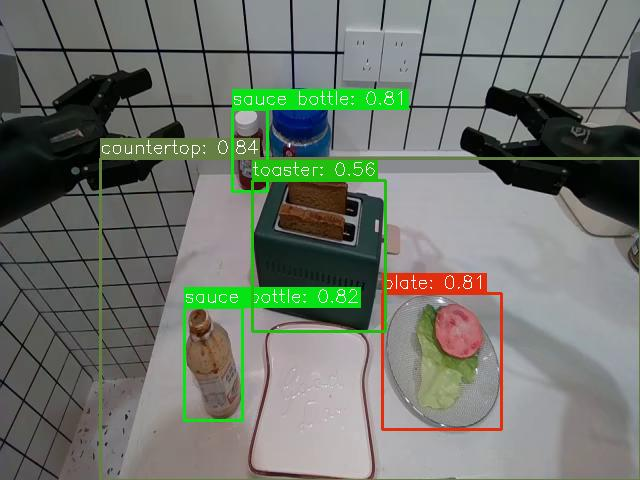

# Способы проверки и улучшения качества разметки


- В рамках моего подхода использовать GPT вместо BLIP - 2 для генерации максимально точного текстового описания изображения и отдельных найденных объектов, а также их свойств

- Можно уйти немного в сторону от моего подхода. А именно дообучить модель детекции на размеченном вручную датасете. Возможно, повторить это несколько
раз внося корректировки и снова проводя дообучение. Делать описание, находить цвет и пространственные отношения мы умеем. Но этому предшествует этап детекции, поэтому очень важно чтобы наша модель детектировала именно то, что мы хотим.  

**Способы проверки разметки и улучшения её качества**


1. **Логическая согласованность**

Проверка, соответствуют ли предсказания здравому смыслу и контексту изображения.

Примеры проверок:

Размеры объектов: Если "человек" имеет bbox размером 10×10 пикселей — вероятно, ошибка.

Отношения между объектами:

"Чашка" не может находиться внутри "холодильника", если последний не обнаружен.

"Машина" не должна парить в небе.
и тд

2. **Задействовать разные модели** (например, YOLOv8, Faster R-CNN, Detectron2) или обученные на разных данных. Генерировать предсказания на одних и тех же изображения и анализировать
- количество обнаруженных объектов
- классификация (совпадают ли названия объектов)
- геометрия bounding boxes (пересекаются ли bbox с высоким IoU)
- confidence
Если модели согласны (например, все обнаружили "стол" в одной области) — разметка надежна.
Если есть конфликт (одна модель видит "стул", другая — "табурет") — такой объект помечается для ручной проверки.
Если объект обнаружен только одной моделью — проверяете его confidence score. Низкий score → вероятно, ложное срабатывание.
Это позволяет снизить количество ошибок за счет "перекрестной проверки", выявить системные слабости отдельных моделей.

3. **Активное обучение**

Модель размечает данные и оценивает свою уверенность (confidence score).

Изображения/объекты с низким confidence (например, <0.5) отправляются эксперту.

Эксперт исправляет ошибки, данные добавляются в тренировочный набор.

Модель дообучается на новых данных.

Критерии для выбора "сомнительных" данных:

- низкий confidence score.

- Противоречия между моделями (см. пункт 2).

- аномалии (редкие классы, необычные комбинации объектов).

4. **Визуальная проверка**

Частичное привлечение человека для валидации сложных случаев.

Варианты:

- Выборочная проверка: Случайный отбор 5-10% изображений.

- Приоритетная проверка: Фокус на изображения с аномальным количеством объектов (например, 50 bbox на фото).

- Объекты с редкими классами

5. **Метрики качества**
Для объектов посчитать precision, recall, mAP
Для bounding boxes посчитать IoU -- насколько они совпадают с эталоном, средний confidence score
Точность описаний например через NLP - метрики типа BLEU для текстовых аннотаций

6. **Дообучение на сложных данных**

Авторазметка → Валидация (пункты 1-5) → Выявление ошибок.

Ошибочные примеры добавляются в тренировочный датасет с корректными разметками.

Модель дообучается с акцентом на проблемные классы/сценарии.

**В итоге я бы предложил такой план:**
- Первичная авторазметка → Межмодельное сравнение → Фильтрация очевидных ошибок.

- Проверка логики: соответствуют ли объекты содержанию наших изображений?

- Активное обучение: отбор "сомнительных" данных для ручной проверки.

- Постобработка: устранение дубликатов, аномалий.

- Визуальный аудит: выборочная проверка экспертом.

- Оценка метрик: отслеживание динамики качества.

- Дообучение: Цикличное улучшение модели.


# Альтернативный подход к детекции: с помощью SAM (segment anything model)

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-2y46x6n7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-2y46x6n7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=690c9a7ee1fda2e2d133fb267ab7c8cdd187838992454fc8681b38c6c8954acd
  Stored in directory: /tmp/pip-ephem-wheel-cache-lqmz6s8a/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.ops import nms as ops_nms
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from urllib.request import urlretrieve


MODEL_PATH = "sam_vit_h_4b8939.pth"
MIN_BOX_AREA = 1500
IOU_THRESHOLD = 0.6

def download_weights_if_missing():
    if not os.path.exists(MODEL_PATH):
        print("Скачиваю веса SAM (~2.6GB)...")
        urlretrieve("https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth", MODEL_PATH)
        print("Скачано!")

def load_sam_model():
    download_weights_if_missing()
    sam = sam_model_registry["vit_h"](checkpoint=MODEL_PATH)
    sam.to("cuda" if torch.cuda.is_available() else "cpu")
    return sam

def generate_masks(image, sam):
    generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=24,
        pred_iou_thresh=0.95,
        stability_score_thresh=0.95,
        min_mask_region_area=10000
    )
    return generator.generate(image)

def mask_to_box(mask: np.ndarray):
    ys, xs = np.where(mask)
    if len(xs) == 0 or len(ys) == 0:
        return np.array([0, 0, 0, 0])
    x0, y0 = xs.min(), ys.min()
    x1, y1 = xs.max(), ys.max()
    return np.array([x0, y0, x1, y1])

def filter_boxes_by_area(masks, image_shape):
    boxes = []
    img_area = image_shape[0] * image_shape[1]
    for mask in masks:
        box = mask_to_box(mask['segmentation'])
        x0, y0, x1, y1 = box
        area = (x1 - x0) * (y1 - y0)
        if area >= MIN_BOX_AREA and area / img_area >= 0.01:
            boxes.append(box.astype(int))
    return boxes

def nms_boxes(boxes, iou_threshold=0.4):
    if not boxes:
        return []
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores = torch.ones(len(boxes))
    keep = ops_nms(boxes_tensor, scores, iou_threshold)
    return [boxes[i] for i in keep]

def visualize_boxes(image, boxes):
    image_copy = image.copy()
    for (x0, y0, x1, y1) in boxes:
        cv2.rectangle(image_copy, (x0, y0), (x1, y1), (0, 255, 0), 2)
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

def generate_bounding_boxes(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Не удалось загрузить изображение: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    sam = load_sam_model()

    masks = generate_masks(image, sam)

    boxes = filter_boxes_by_area(masks, image.shape[:2])

    boxes = nms_boxes(boxes, 0.4)

    return boxes

image_path = "/content/images/599_810525.jpg"
boxes = generate_bounding_boxes(image_path)

image = cv2.imread(image_path)
visualize_boxes(image, boxes)

print("Обнаружено bounding boxes:")
for i, box in enumerate(boxes):
    print(f"Box {i+1}: {box}")

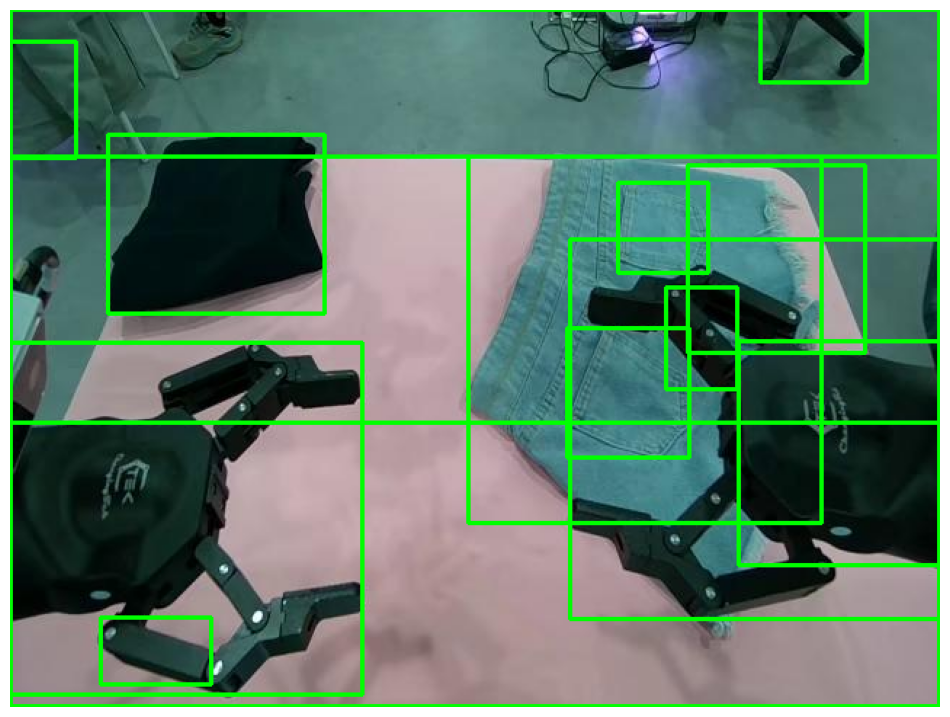

Обнаружено bounding boxes:
Box 1: [ 67  86 216 209]
Box 2: [501 228 639 382]
Box 3: [315 101 558 353]
Box 4: [  0 101 639 479]
Box 5: [  0   0 639 284]
Box 6: [  0 229 242 471]
Box 7: [383 219 467 308]
Box 8: [418 119 480 181]
Box 9: [385 158 639 419]
Box 10: [  0  22  45 102]
Box 11: [ 62 418 138 464]
Box 12: [466 107 588 236]
Box 13: [516   0 589  50]
Box 14: [451 191 500 261]


In [ ]:
image_path = "/content/images/599_810525.jpg"
boxes = generate_bounding_boxes(image_path)

image = cv2.imread(image_path)
visualize_boxes(image, boxes)

print("Обнаружено bounding boxes:")
for i, box in enumerate(boxes):
    print(f"Box {i+1}: {box}")